In [14]:
# import packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# set the aesthetic style of the plots
sns.set_style()
pd.set_option('display.max_rows', None)  # None means unlimited rows
pd.set_option('display.max_columns', None) # None means unlimited columns
pd.set_option('display.width', None)      # None means auto-detect width
pd.set_option('display.max_colwidth', None) # N
# filter warning messages
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# df_credit = pd.read_csv('data/Birmingham/Loan_status_2007-2020Q3.gzip',low_memory=True)
# df_credit_card = df_credit[df_credit['purpose'] == 'credit_card']
# df_credit_card.to_csv('data/Birmingham/credit_card_loans.csv', index=False)

In [28]:
df_credit = pd.read_csv('data/Birmingham/credit_card_loans.csv')


In [29]:
loan_data_original_df = df_credit

In [30]:
'''
Remove certain columns from loan dataset as they are not helpful in analysing the loan approval

-> id and url columns contains unique ID or url for each customers, does not have other meaning
-> similarly, zip_code, title and employment title columns are also removed
-> inq_fi: Number of personal finance inquiries by LendingClub
-> mths_since_recent_inq: Months since most recent inquiry
-> inq_last_6mths: The number of inquiries in past 6 months.

A credit inquiry is a request put up by a financial institution or firm for the credit report information of an individual from a 
credit reporting bureau, so it not related to characteristics of loan or behavioral payments.
Information which only served the purpose of administration like this should be removed
'''
# Drop above columns
loan_data_original_df.drop(columns=['Unnamed: 0', # Row number in the dataset
                                    'url', # URL 
                                    'id', # A unique assigned ID for the loan listing.
                                    'zip_code', # zip code provided by the borrower 
                                    'title', # The loan title provided by the borrower
                                    'emp_title', # The job title supplied by the Borrower when applying for the loan
                                    # 'inq_fi', # Number of personal finance inquiries
                                    # 'mths_since_recent_inq', # Months since most recent inquiry.
                                    # 'inq_last_6mths', # The number of inquiries in past 6 months 
                                    # 'inq_last_12m' # The number of inquiries in past 12 months 
                                    ],
                            inplace=True)

#removed purpose column because we use only cretit_card loans here
loan_data_original_df.drop(columns=['purpose'                    
                                    ],
                            inplace=True)

In [32]:
# Remove categorical columns which has very high proportion of only one category
# Finally, Removing Column that bring little information for loan approval prediction
loan_data_original_df.drop(columns=['chargeoff_within_12_mths', 'tax_liens', 'policy_code', 'num_tl_120dpd_2m', 'num_tl_30dpd', 
                 'num_tl_90g_dpd_24m', 'pymnt_plan', 'acc_now_delinq', 'debt_settlement_flag', 'delinq_amnt'], inplace=True)

In [31]:
'''
There are also columns presenting what happens after a loan is granted. 
They should be dropped for two reasons:
  -> Loan Approval Prediction should be done using the attributes that are relevant before the loan is granted  
  -> Attributes that are available after loans are granted, it might easily indicate if a borrower is going to default or not. 
    Hence, to avoid the overfitting model, they must be dropped. 
They are the information related to funded amount, funds issued date, last payment date, recoveries, installments, or hardship. 
For example, hardship_flag should be removed because it is applied as a last resort for a borrower when he/she is struggling to pay monthly
   installments after getting the loan.
'''

loan_data_original_df.drop(columns=['funded_amnt', 'funded_amnt_inv', 'out_prncp', 'out_prncp_inv', 'last_fico_range_low',
                                    'last_fico_range_high','total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
                                    'total_rec_late_fee', 'recoveries', 'collection_recovery_fee','tot_coll_amt','last_pymnt_amnt',
                                    'total_il_high_credit_limit', 'hardship_flag', 'installment', 
                                    'revol_util','collections_12_mths_ex_med','next_pymnt_d'],
                inplace=True)

# Removing the date columns, which are created after the loan has been issues. Therefore, does not play any role in analysis
loan_data_original_df.drop(columns = ['issue_d','last_pymnt_d','last_credit_pull_d'], inplace = True)

In [35]:
# Step 2: drop columns with more than 80% null values
loan_data_original_df.dropna(thresh = loan_data_original_df.shape[0]*0.2, axis = 1, inplace = True)

In [36]:
loan_data_original_df.shape

(695665, 70)

In [38]:
# Function to calculate correlation between numerical columns
def correlation(dataset, threshold):
    col_corr = []  # Set of all the names of correlated columns
    corr_matrix = dataset.corr() # Compute the correlation
    for i in range(len(corr_matrix.columns)): # Iterate through all binary column pairs
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # Append the both column names if the calculated correlation is more than threshold            		
                colname_1 = corr_matrix.columns[i]
                colname_2 = corr_matrix.columns[j]
                col_corr.append((colname_1,colname_2))
    return col_corr

# Filter the names of columns which are numerical in the dataset
numerical_columns = loan_data_original_df.select_dtypes(include=['float','int']).columns.values

# Calculate the correlation between numerical columns and set the threshold=0.8
correlation(dataset = loan_data_original_df[numerical_columns],threshold = 0.8)

[('fico_range_high', 'fico_range_low'),
 ('total_rev_hi_lim', 'revol_bal'),
 ('acc_open_past_24mths', 'open_rv_24m'),
 ('avg_cur_bal', 'tot_cur_bal'),
 ('mths_since_recent_revol_delinq', 'mths_since_last_delinq'),
 ('num_actv_rev_tl', 'num_actv_bc_tl'),
 ('num_bc_sats', 'num_actv_bc_tl'),
 ('num_op_rev_tl', 'open_acc'),
 ('num_op_rev_tl', 'num_actv_rev_tl'),
 ('num_rev_accts', 'num_bc_tl'),
 ('num_rev_accts', 'num_op_rev_tl'),
 ('num_rev_tl_bal_gt_0', 'num_actv_bc_tl'),
 ('num_rev_tl_bal_gt_0', 'num_actv_rev_tl'),
 ('num_rev_tl_bal_gt_0', 'num_op_rev_tl'),
 ('num_sats', 'open_acc'),
 ('num_sats', 'num_op_rev_tl'),
 ('num_tl_op_past_12m', 'open_rv_12m'),
 ('percent_bc_gt_75', 'bc_util'),
 ('tot_hi_cred_lim', 'tot_cur_bal'),
 ('total_bal_ex_mort', 'total_bal_il'),
 ('total_bc_limit', 'bc_open_to_buy')]

In [39]:
'''
Columns 'fico_range_high' and 'fico_range_low' can be removed and instead average FICO score can be used for analysis
'''
loan_data_original_df['avg_fico_range'] = (loan_data_original_df['fico_range_high'] + loan_data_original_df['fico_range_low'])/2
loan_data_original_df.drop(['fico_range_high','fico_range_low'],axis=1,inplace=True)

In [40]:

correlated_columns_to_drop = ['num_sats',   # As it is correlating with two columns, ie, open_acc and num_op_rev_tl
'num_rev_tl_bal_gt_0',   # As it is correlating with two columns, ie, num_actv_bc_tl and num_actv_rev_tl
'tot_hi_cred_lim',
'bc_open_to_buy',
'percent_bc_gt_75',
'total_bal_ex_mort',
'num_rev_accts', # As it is correlating with two columns
'num_actv_bc_tl',  # As it is correlating with three columns, ie, num_actv_rev_tl, num_bc_sats and num_rev_tl_bal_gt_0
'avg_cur_bal',
'open_rv_12m',
'acc_open_past_24mths',
'mths_since_recent_revol_delinq',
'num_op_rev_tl',
'total_rev_hi_lim'
]

# Finally, drop one of the columns from highly correlated column pairs
loan_data_original_df.drop(correlated_columns_to_drop,axis=1,inplace=True)

<Axes: >

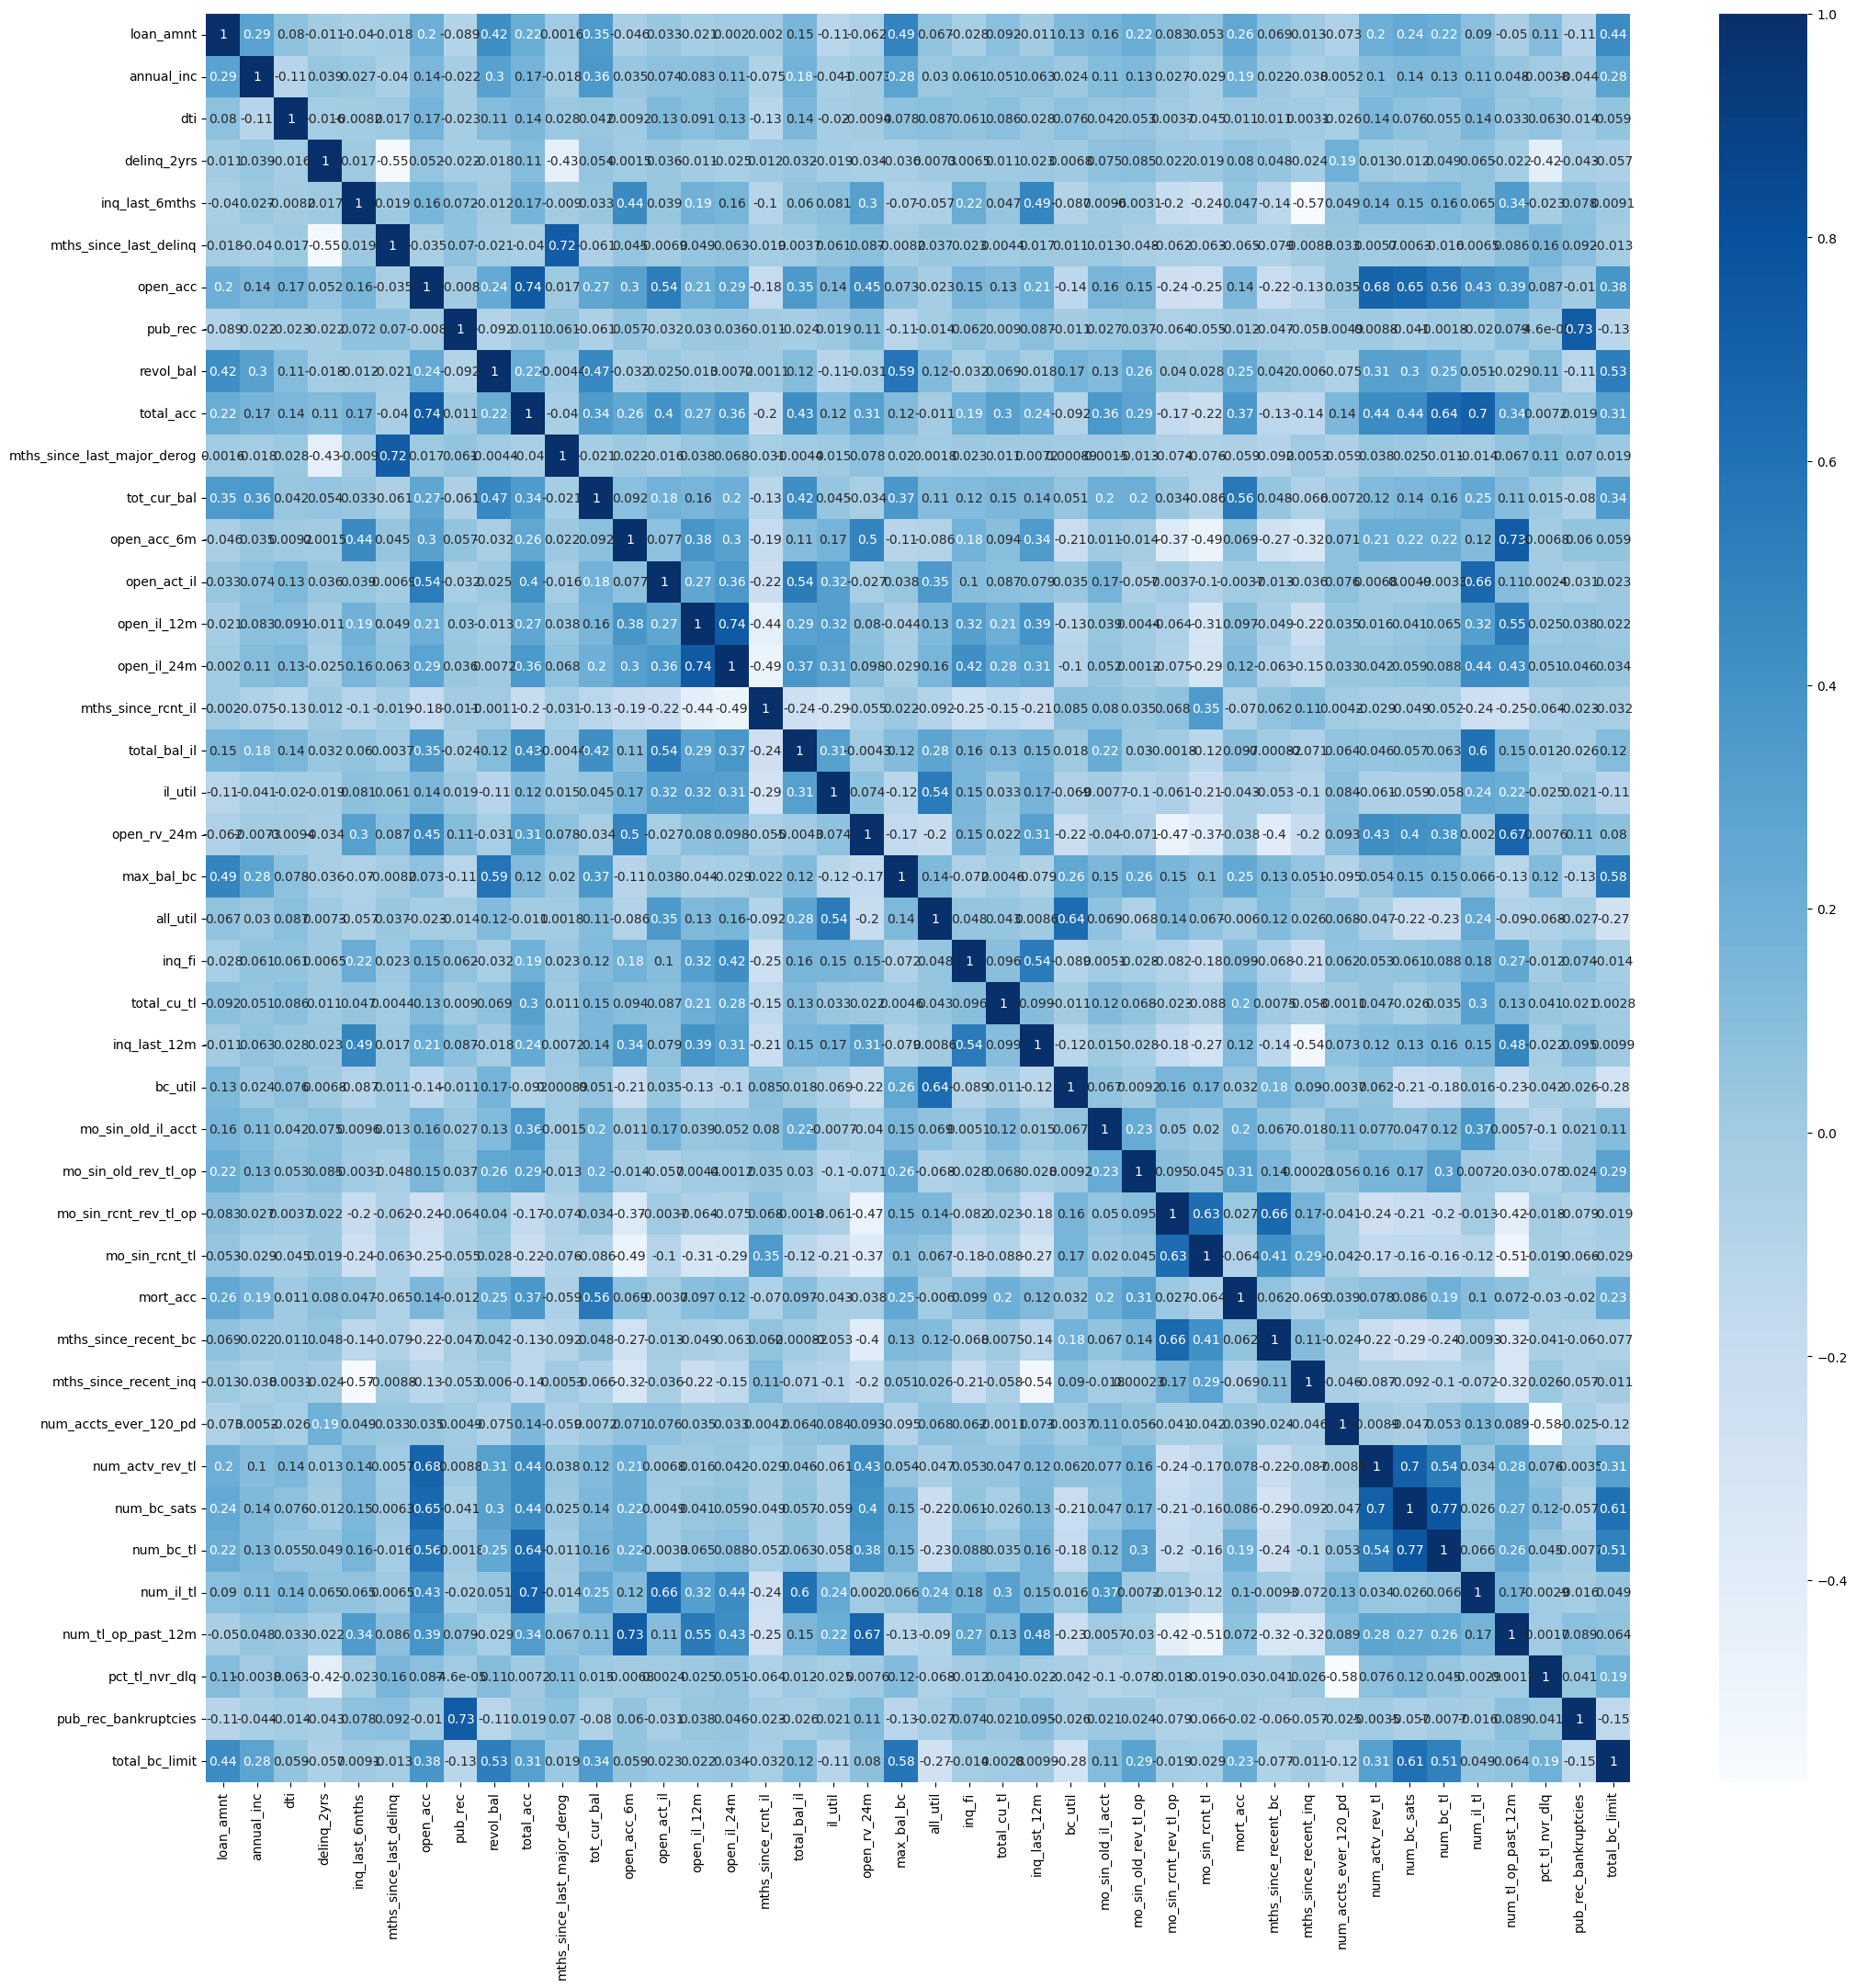

In [42]:
# final check with correlation matrix heatmap
plt.figure(figsize=(25,25))        
sns.heatmap(loan_data_original_df[[col for col in [num_col for num_col in numerical_columns if num_col not in ['fico_range_low', 'fico_range_high']] if col not in correlated_columns_to_drop]].corr(), annot=True, cmap="Blues")

In [44]:
'''
Removing the Sub-Grade column and keeping the Grade columns as they both 
are typically used to convey information about the creditworthiness and risk profile of a borrower in terms of ratings. 
However, Grade is broader categorical rating than sub-grade that is assigned to a borrower based on their credit history
'''
loan_data_original_df.drop(['sub_grade'],axis=1,inplace=True)

In [43]:
loan_data_original_df.shape

(695665, 55)

In [46]:
loan_data_original_df.to_csv('data/Birmingham/cleaned_credit_card.csv', index=False)